In [ ]:
# Import dependencies
import numpy as np
from numpy import newaxis
import pandas as pd
!pip install keras
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.recurrent import LSTM, GRU
# from keras.models import Sequential
# from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Enter in how many steps we will enroll the network.

Enrol_window = 100

print ('enroll window set to', Enrol_window )

enroll window set to 100


In [64]:
# Support functions
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

# def normalize_windows(window_data):
#     # A support function to normalize a dataset
#     normalised_data = []
#     for window in window_data:
#         normalised_window = [((float(p) / float(window[0]) - 1) if window[0] != 0 else 0) for p in window]
#         normalised_data.append(normalised_window)
#     return normalised_data

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        if window[0] != 0:
            normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        else:
            normalised_window = [0 for _ in window]
        normalised_data.append(normalised_window)
    return normalised_data

# def normalise_windows(window_data):
#     # A support function to normalize a dataset
#     normalised_data = []
#     for window in window_data:
#         normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
#         normalised_data.append(normalised_window)
#     return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [51]:
# Upload CSV file
from google.colab import files
uploaded = files.upload()

Saving eth_all_features (4).csv to eth_all_features (4) (3).csv


In [52]:
# Read Eth data
dataset = pd.read_csv('eth_all_features (4).csv', index_col='Unnamed: 0', parse_dates=True)
print(dataset)

                 Open       High        Low      Close  Volume  \
2021-10-25  91.089996  91.089996  91.089996  91.089996     0.0   
2021-10-26  91.339996  91.339996  91.339996  91.339996     0.0   
2021-10-27  88.010002  88.010002  88.010002  88.010002     0.0   
2021-10-28  87.309998  87.309998  87.309998  87.309998     0.0   
2021-10-29  86.570000  86.570000  86.570000  86.570000     0.0   
...               ...        ...        ...        ...     ...   
2023-08-28  41.240002  41.240002  41.240002  41.240002     0.0   
2023-08-29  42.130001  42.130001  42.130001  42.130001     0.0   
2023-08-30  43.110001  43.110001  43.110001  43.110001     0.0   
2023-08-31  43.189999  43.189999  43.189999  43.189999     0.0   
2023-09-01  42.270000  42.270000  42.270000  42.270000     0.0   

            Personal Saving %  Close/Last  
2021-10-25                6.6     4566.48  
2021-10-26                6.6     4574.79  
2021-10-27                6.6     4551.68  
2021-10-28                6.6  

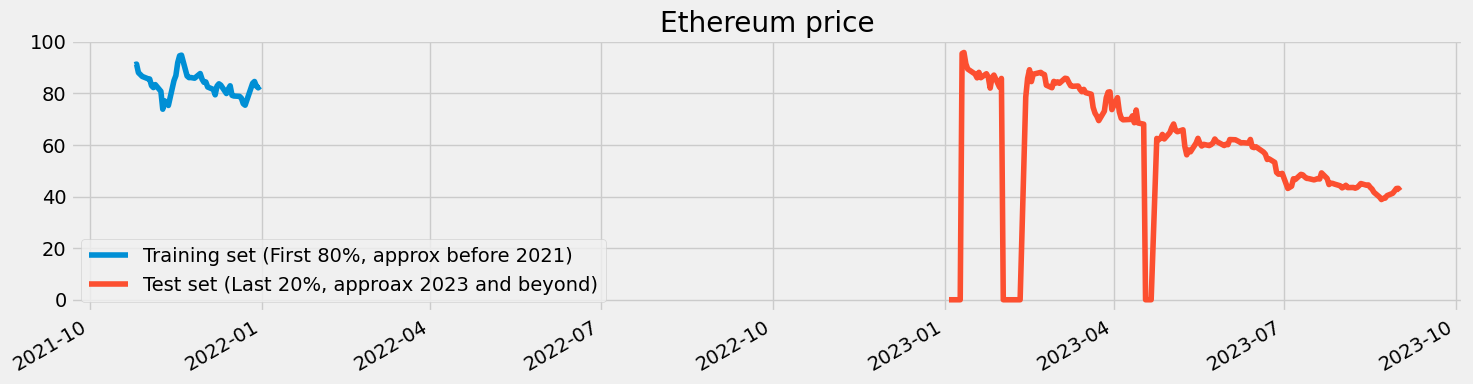

In [65]:
# Prepare the dataset, note that the eth price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case ethereum price
# Selected 'Close' (eth price at closing) attribute for prices. Let's see what it looks like
# def load_data(dataset, target, Enrol_window, is_split_train_test):
#     # Load the dataset

#     # Split the data into training and testing sets
#     if is_split_train_test:
#         split_index = int(len(data) * 0.8)
#         feature_train = data[:split_index, :-1]
#         label_train = data[:split_index, -1]
#         feature_test = data[split_index:, :-1]
#         label_test = data[split_index:, -1]
#     else:
#         feature_train = data[:, :-1]
#         label_train = data[:, -1]

#     # Remove the zero values from the windows
#     feature_train = [window for window in feature_train if window[0] != 0]
#     feature_test = [window for window in feature_test if window[0] != 0]

#     return feature_train, label_train, feature_test, label_test

# # Load the training and testing data
# feature_train, label_train, feature_test, label_test = load_data('dataset.csv', 'Close', 10, True)
feature_train, label_train, feature_test, label_test = load_data(dataset, 'Close', Enrol_window, True)

dataset["Close"][:'2021'].plot(figsize=(16,4),legend=True)
dataset["Close"]['2023':].plot(figsize=(16,4),legend=True) # 20% is used for training data which is approx 2022 data
plt.legend(['Training set (First 80%, approx before 2021)','Test set (Last 20%, approax 2023 and beyond)'])
plt.title('Ethereum price')
plt.show()

In [ ]:
hvplot.extension('bokeh')

eth_price_prediction_lstm_df.hvplot.line(title = "actual eth price vs. predicted eth prices with lstm").opts(width = 800)

In [66]:
# The same LSTM model I would like to test, lets see if the sinus prediction results can be matched

model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')

print (model.summary())

model compiled
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 100, 50)           7950      
                                                                 
 dropout_4 (Dropout)         (None, 100, 50)           0         
                                                                 
 gru_5 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53651 (209.57 KB)
Trainable params: 53651 (209.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
N

In [67]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 0.1911 - val_loss: 0.1305
Epoch 2/5
1/1 [==============================] - 1s 580ms/step - loss: 0.1487 - val_loss: 0.0745
Epoch 3/5
1/1 [==============================] - 1s 565ms/step - loss: 0.1130 - val_loss: 0.0346
Epoch 4/5
1/1 [==============================] - 1s 544ms/step - loss: 0.0890 - val_loss: 0.0107
Epoch 5/5
1/1 [==============================] - 1s 566ms/step - loss: 0.0736 - val_loss: 0.0013


2/2 [==============================] - 1s 20ms/step


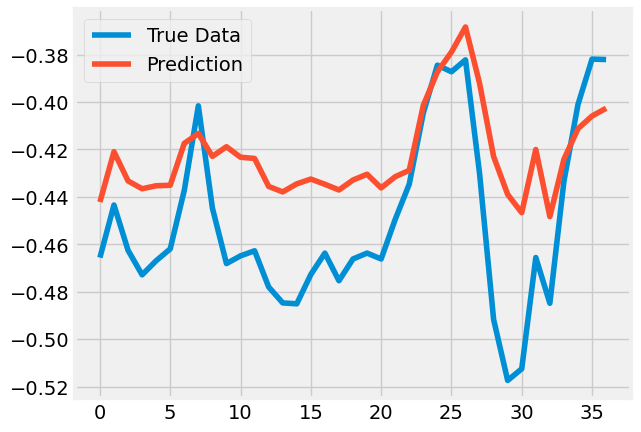

In [68]:
# Model and predict the eth price
predicted_eth_price = model.predict(feature_test)
plot_results(predicted_eth_price,label_test)

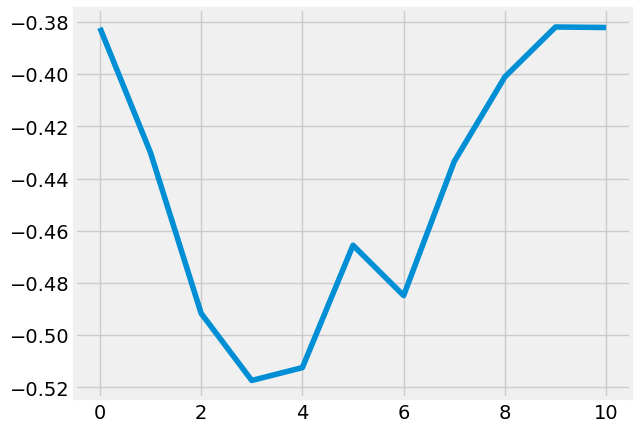

In [ ]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
plot_results_multiple(predictions, label_test, 50)